In [85]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [86]:
data = pd.read_csv('files/merged_movies.csv')

### For now use the weighted rating

In [87]:
data = data.drop_duplicates(subset ='tconst')

In [88]:
print(data.shape)
data.columns

(33295, 37)


Index(['tconst', 'primaryTitle', 'originalTitle', 'runtimeMinutes', 'genres_x',
       'averageRating', 'numVotes', 'has_well_known_director',
       'directors_name', 'has_well_known_actors', 'primary_actors', 'id_int',
       'keywords', 'belongs_to_collection', 'budget', 'genres_y', 'homepage',
       'original_language', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'tagline', 'vote_average', 'vote_count',
       'weighted_rating', 'adjusted_budget', 'adjusted_revenue',
       'original_english', 'has_production_companies',
       'is_top_production_company', 'release_month', 'has_tag_line'],
      dtype='object')

### Select cols for model

In [89]:
cols = ['runtimeMinutes', 'averageRating','numVotes','weighted_rating', 'runtime','vote_average','vote_count', # important features
        'genres_x', 'genres_y', 'adjusted_budget', 'adjusted_revenue', 'release_month', # possible predictive features
        'has_well_known_director','has_well_known_actors', 'is_top_production_company', # binary extracted features
        'production_countries','belongs_to_collection','has_tag_line','homepage','spoken_languages','original_english',
        'popularity','keywords','overview','directors_name','primary_actors' # for text
        ]
movie_models = data[cols]

In [90]:
# for now select those with at least 5k votes
movie_models = movie_models[movie_models['numVotes'] > 5000]

In [91]:
remove_for_now_cols = ['runtime','vote_average','vote_count','genres_y','keywords','overview','primary_actors','directors_name','adjusted_revenue']
model_cols = [col for col in movie_models.columns if col not in remove_for_now_cols]
movie_models = movie_models[model_cols]

In [92]:
movie_models.isnull().sum()

runtimeMinutes               0
averageRating                0
numVotes                     0
weighted_rating              0
genres_x                     0
adjusted_budget              1
release_month                1
has_well_known_director      0
has_well_known_actors        0
is_top_production_company    0
production_countries         0
belongs_to_collection        0
has_tag_line                 0
homepage                     0
spoken_languages             0
original_english             0
popularity                   0
dtype: int64

In [93]:
# same size as basic data
movie_models = movie_models[movie_models['adjusted_budget'].notnull()]

In [94]:
# binary weighted rating for now
movie_models['weighted_rating_original'] = movie_models['weighted_rating']
movie_models['weighted_rating'] = (movie_models['weighted_rating'] > 7).astype(int)

### Preprocessing

#### Convert month into category

In [95]:
import calendar

movie_models['release_month'] = movie_models.release_month.apply(lambda x: calendar.month_name[int(x)])

### Convert columns

In [96]:
movie_models.dtypes

runtimeMinutes               float64
averageRating                float64
numVotes                     float64
weighted_rating                int32
genres_x                      object
adjusted_budget              float64
release_month                 object
has_well_known_director        int64
has_well_known_actors          int64
is_top_production_company      int64
production_countries           int64
belongs_to_collection          int64
has_tag_line                   int64
homepage                       int64
spoken_languages               int64
original_english               int64
popularity                   float64
weighted_rating_original     float64
dtype: object

In [97]:
num_cols = ['runtimeMinutes','adjusted_budget','production_countries','spoken_languages']
cat_cols1 = ['genres_x','release_month']
cat_cols2 = ['has_well_known_director','has_well_known_actors','is_top_production_company',
            'belongs_to_collection','has_tag_line','homepage','original_english']

In [98]:
movie_models[cat_cols2] = movie_models[cat_cols2].astype(object)

In [99]:
movie_models.dtypes.sort_values()

weighted_rating                int32
spoken_languages               int64
production_countries           int64
runtimeMinutes               float64
popularity                   float64
weighted_rating_original     float64
numVotes                     float64
averageRating                float64
adjusted_budget              float64
release_month                 object
has_well_known_director       object
genres_x                      object
is_top_production_company     object
belongs_to_collection         object
has_tag_line                  object
homepage                      object
original_english              object
has_well_known_actors         object
dtype: object

#### Filter those with budget > 0

In [100]:
movie_models = movie_models[movie_models['adjusted_budget'] > 0]

In [101]:
pd.qcut(movie_models['weighted_rating_original'], 10, duplicates= 'drop').value_counts().sort_index()

(2.81, 5.884]     619
(5.884, 6.155]    619
(6.155, 6.311]    619
(6.311, 6.428]    619
(6.428, 6.555]    619
(6.555, 6.679]    618
(6.679, 6.853]    619
(6.853, 7.078]    619
(7.078, 7.464]    619
(7.464, 9.273]    619
Name: weighted_rating_original, dtype: int64

In [102]:
from scipy.stats import percentileofscore

percentileofscore(movie_models['weighted_rating_original'], 7)

76.74907093229925

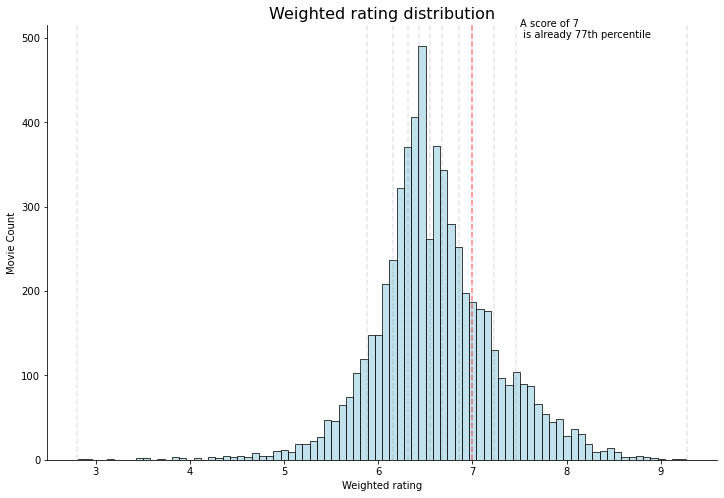

In [103]:
quantiles = [2.8, 5.884, 6.155, 6.311, 6.428,  6.555,  6.679, 6.853, 7.464, 7.224, 9.273]

with sns.axes_style({
'xtick.bottom': True,
 'xtick.top': False,
 'ytick.left': True,
 'ytick.right': False,
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': False,
 'axes.spines.top': False
}):
    plt.figure(figsize=(12,8))
    sns.histplot(movie_models['weighted_rating_original'], color = 'lightblue')
    plt.xlabel('Weighted rating')
    plt.ylabel('Movie Count')
    plt.title('Weighted rating distribution', fontsize = 16)

    for point in quantiles:
        plt.axvline(point, color = 'gray', alpha = .2, linestyle = '--')
    plt.axvline(7, color ='red', alpha = .5, linestyle = '--')
    plt.text(7.5, 500, 'A score of 7\n is already 77th percentile')

In [104]:
movie_models.shape

(6189, 18)

#### Dummy variables for genre

In [105]:
genres_dummy =  movie_models['genres_x'].str.get_dummies(',')
genres_dummy

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Music,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western
21,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
33,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
62,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
86,0,0,0,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
101,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33330,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33353,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
33363,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33393,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [106]:
# save df for viz later
movie_models_originals = movie_models.copy()
movie_models_originals.shape

(6189, 18)

#### Concat genres dummy

In [107]:
movie_models = pd.concat([movie_models, genres_dummy], axis = 1)

In [108]:
movie_models.columns

Index(['runtimeMinutes', 'averageRating', 'numVotes', 'weighted_rating',
       'genres_x', 'adjusted_budget', 'release_month',
       'has_well_known_director', 'has_well_known_actors',
       'is_top_production_company', 'production_countries',
       'belongs_to_collection', 'has_tag_line', 'homepage', 'spoken_languages',
       'original_english', 'popularity', 'weighted_rating_original', 'Action',
       'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music',
       'Musical', 'Mystery', 'News', 'Romance', 'Sci-Fi', 'Sport', 'Thriller',
       'War', 'Western'],
      dtype='object')

In [109]:
movie_models.drop(columns=['genres_x','popularity','averageRating','numVotes','weighted_rating_original'], inplace= True)

In [110]:
print(movie_models.shape)
movie_models.head()

(6189, 36)


,runtimeMinutes,weighted_rating,adjusted_budget,release_month,has_well_known_director,has_well_known_actors,is_top_production_company,production_countries,belongs_to_collection,has_tag_line,...,Music,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western
21,195.0,0,2.486208e+06,February,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
33,163.0,0,1.933927e+08,September,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
62,76.0,1,2.259963e+05,February,0,0,0,1,0,1,...,0,0,1,0,0,0,0,1,0,0
86,68.0,1,3.507081e+06,January,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
101,78.0,0,7.921828e+05,June,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [111]:
# log of budget
movie_models['adjusted_budget'] = np.log(movie_models['adjusted_budget'])

#### Dummy variables for month

In [112]:
# month_dummies =  movie_models['release_month'].str.get_dummies()
# movie_models = pd.concat([movie_models, month_dummies], 1)
# movie_models.drop(columns=['release_month'], inplace= True)

#### Random shuffling for baseline

              precision    recall  f1-score   support

           0       0.76      0.76      0.76      4750
           1       0.22      0.22      0.22      1439

    accuracy                           0.64      6189
   macro avg       0.49      0.49      0.49      6189
weighted avg       0.64      0.64      0.64      6189

Logloss 12.578979340835756


[Text(0.5, 0, 'Predicted 0'), Text(1.5, 0, 'Predicted 1')]

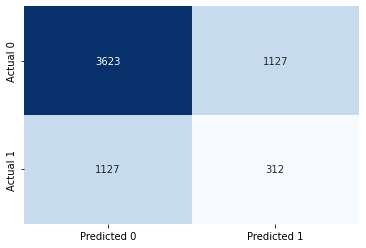

In [113]:
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report, roc_auc_score, confusion_matrix, log_loss
y = movie_models['weighted_rating'].values
y_shuffle = shuffle(y)


print(classification_report(y_pred= y_shuffle, y_true= y))
print('Logloss', log_loss(y_pred= y_shuffle, y_true= y))

cm = confusion_matrix(y_pred= y_shuffle, y_true= y)
g = sns.heatmap(cm, annot=True, cbar = False, fmt = 'g', cmap ='Blues')
g.set_yticklabels(['Actual 0', 'Actual 1'])
g.set_xticklabels(['Predicted 0', 'Predicted 1'])

#### Split data

In [114]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(movie_models.drop(columns=['weighted_rating'], axis = 1), movie_models['weighted_rating'], 
                                        stratify= movie_models['weighted_rating'], test_size=.25, random_state=42)

In [115]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] =  scaler.transform(X_test[num_cols])

In [116]:
import category_encoders as ce
encoder = ce.TargetEncoder(cols =  ['release_month'] +  cat_cols2 + list(genres_dummy.columns))
X_train_trans = encoder.fit_transform(X_train, y_train)
X_test_trans = encoder.transform(X_test)

# X_train_trans = X_train
# X_test_trans = X_test

In [117]:
print(X_train_trans.shape)
print(X_test_trans.shape)
print(y_train.mean())
print(y_test.mean())

(4641, 35)
(1548, 35)
0.23249299719887956
0.23255813953488372


In [118]:
X_train_trans.head()

,runtimeMinutes,adjusted_budget,release_month,has_well_known_director,has_well_known_actors,is_top_production_company,production_countries,belongs_to_collection,has_tag_line,homepage,...,Music,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western
32647,1.328592,-0.324641,0.235935,0.202145,0.216353,0.272099,-0.486618,0.235653,0.162328,0.208724,...,0.232563,0.230904,0.23535,0.232328,0.242853,0.231962,0.232225,0.195031,0.229052,0.231021
21773,-0.780342,0.038247,0.232104,0.202145,0.216353,0.214532,-0.486618,0.235653,0.162328,0.280078,...,0.232563,0.230904,0.23535,0.232328,0.242853,0.231962,0.232225,0.240355,0.229052,0.231021
25427,-0.209172,-0.773568,0.235935,0.202145,0.216353,0.214532,-0.486618,0.235653,0.243982,0.280078,...,0.232563,0.230904,0.23535,0.232328,0.179420,0.231962,0.232225,0.240355,0.229052,0.231021
21501,-0.956086,0.112470,0.202941,0.202145,0.216353,0.214532,-0.486618,0.221470,0.243982,0.208724,...,0.232563,0.230904,0.23535,0.232328,0.242853,0.231962,0.232225,0.240355,0.229052,0.231021
28456,-0.868214,-0.491424,0.191136,0.202145,0.477352,0.214532,-0.486618,0.235653,0.243982,0.208724,...,0.232563,0.230904,0.23535,0.232328,0.179420,0.231962,0.232225,0.240355,0.229052,0.231021


### Modeling

In [119]:

def measure_metrics(model, y_pred, y_true, X_train = X_train, X_test = X_test):
     print(classification_report(y_pred= y_pred, y_true= y_test))
     proba_train = model.predict_proba(X_train)[:,1]
     proba_test = model.predict_proba(X_test)[:,1]
     
     print(f"AUC train:{round(roc_auc_score(y_train, proba_train),4)}")
     print(f"AUC test :{round(roc_auc_score(y_test, proba_test),4)}\n")
     print('Logloss', log_loss(y_pred= y_pred, y_true= y_test))

     print('*' * 100)
     print('Confusion matrix')     
     cm = confusion_matrix(y_pred= y_pred, y_true= y_test)
     g = sns.heatmap(cm, annot=True, cbar = False, fmt = 'g', cmap ='Blues')
     g.set_yticklabels(['Actual 0', 'Actual 1'])
     g.set_xticklabels(['Predicted 0', 'Predicted 1'])

#### Naive Bayes

Quick NB as baseline metrics

              precision    recall  f1-score   support

           0       0.83      0.81      0.82      1188
           1       0.42      0.45      0.43       360

    accuracy                           0.73      1548
   macro avg       0.62      0.63      0.63      1548
weighted avg       0.73      0.73      0.73      1548

AUC train:0.731
AUC test :0.7337

Logloss 9.460350581433321
****************************************************************************************************
Confusion matrix


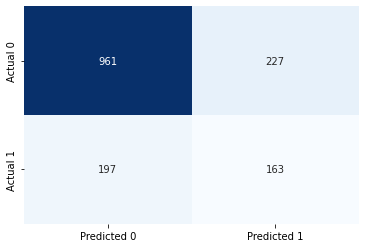

In [120]:
import seaborn as sns
from sklearn.naive_bayes import GaussianNB, MultinomialNB

NB_clf = GaussianNB()
NB_clf.fit(X_train_trans, y_train)


y_pred  =  NB_clf.predict(X_test_trans)

measure_metrics(NB_clf, y_pred= y_pred, y_true= y_test, X_train= X_train_trans, X_test= X_test_trans)


### Random Forest

Identify feature importances.

In [121]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

params = {'bootstrap': [True, False],
               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4],
               'min_samples_split': [2, 5, 10],
               'n_estimators': [130, 180, 230], 
               'class_weight': ['balanced',{0:1,1:2}, {0:1, 1:3}]}


rf_clf = RandomForestClassifier()
rf_grid = RandomizedSearchCV(estimator = rf_clf, scoring='f1', param_distributions= params, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

rf_grid.fit(X_train_trans, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced',
                                                         {0: 1, 1: 2},
                                                         {0: 1, 1: 3}],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [130, 180, 230]},
                   random_state=42, scoring='f1', verbose=2)

In [122]:
best_rf = rf_grid.best_estimator_
best_rf

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       max_features='sqrt', min_samples_leaf=4,
                       min_samples_split=10, n_estimators=130)

              precision    recall  f1-score   support

           0       0.87      0.79      0.83      1188
           1       0.47      0.62      0.54       360

    accuracy                           0.75      1548
   macro avg       0.67      0.70      0.68      1548
weighted avg       0.78      0.75      0.76      1548

AUC train:0.8765
AUC test :0.7943

Logloss 8.590197940959865
****************************************************************************************************
Confusion matrix


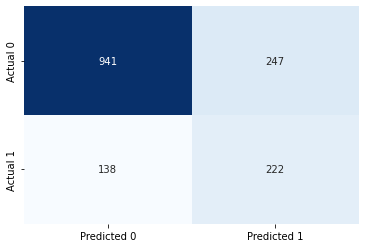

In [123]:
y_pred  =  best_rf.predict(X_test_trans)
measure_metrics(best_rf, y_pred= y_pred, y_true= y_test, X_train= X_train_trans, X_test= X_test_trans)

In [124]:
importances = pd.Series(best_rf.feature_importances_, index = X_train_trans.columns)
importances = importances.sort_values(ascending = False)[:15]
importances = np.round(importances, 3)

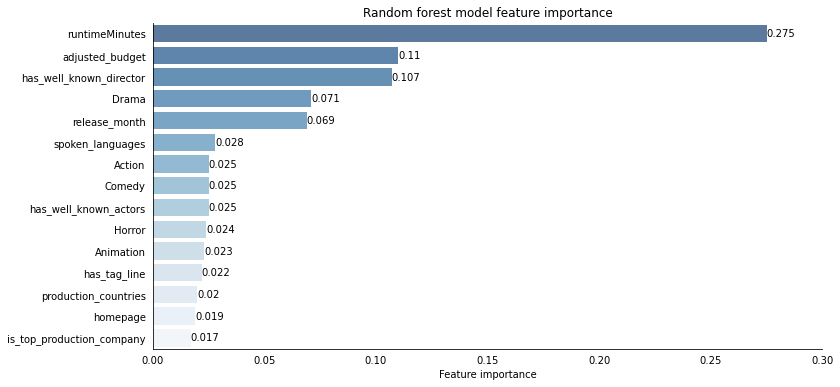

In [125]:
with sns.axes_style({
    'xtick.bottom': False,
    'xtick.top': False,
    'ytick.left': False,
    'ytick.right': False,
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.right': False,
    'axes.spines.top': False
    }):
    plt.figure(figsize=(12,6))
    plt.title('Random forest model feature importance')
    sns.barplot(y = importances.index, x = importances.values, orient= 'h', palette='Blues_r' , alpha = .7)
    plt.ylabel('')
    plt.xlabel('Feature importance')
    plt.xlim(0, .3)

    for i, num_movies in enumerate(importances):
        plt.text(num_movies,i,num_movies,va="center")

## Plots

#### Runtime minutes

In [126]:
movie_models_originals['weighted_rating_original'] = np.round(movie_models_originals['weighted_rating_original'], 1)

In [127]:
def plot_boxplot(df, grouping,title = 'title',  xlabel = 'xlabel', ylabel = 'ylabel', order = None):
    temp_data_median = df.groupby(grouping)['weighted_rating_original'].median()
    if order == None: 
        temp_data_median= temp_data_median.sort_values(ascending = False)
        order = temp_data_median.index.values
    else: 
        temp_data_median = temp_data_median.loc[order]

    with sns.axes_style({
    'xtick.bottom': False,
    'xtick.top': False,
    'ytick.left': False,
    'ytick.right': False,
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.right': False,
    'axes.spines.top': False
    }):
        plt.figure(figsize = (12,8))
        plt.title(title, fontsize = 16)
        sns.boxplot(data = df, y = grouping, x = 'weighted_rating_original', order= order, color = 'skyblue')
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)

        for i, rating in enumerate(temp_data_median):
            plt.text(rating + .1, i +.2, rating)

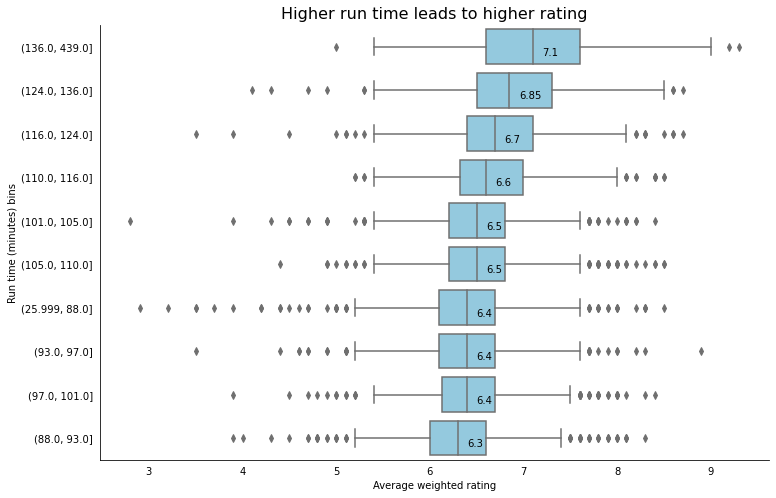

In [128]:
plot_boxplot(movie_models_originals,pd.qcut(movie_models['runtimeMinutes'], 10), 
            title = 'Higher run time leads to higher rating',
             xlabel = 'Average weighted rating', ylabel = 'Run time (minutes) bins')

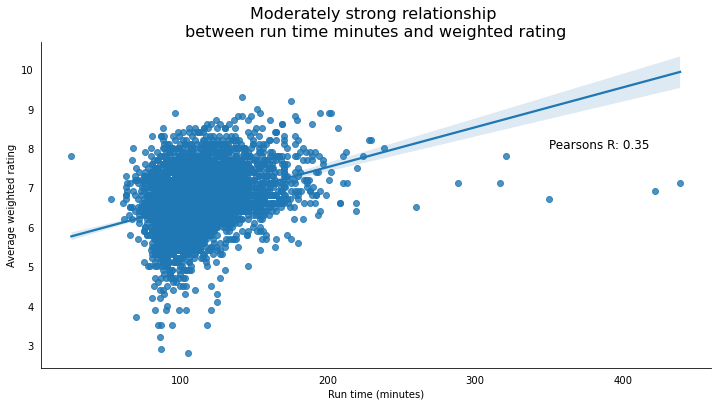

In [129]:
with sns.axes_style({
'xtick.bottom': False,
 'xtick.top': False,
 'ytick.left': False,
 'ytick.right': False,
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': False,
 'axes.spines.top': False
}):
    plt.figure(figsize=(12,6))
    sns.regplot(data = movie_models_originals, x = 'runtimeMinutes', y= 'weighted_rating_original')
    plt.title('Moderately strong relationship \nbetween run time minutes and weighted rating', fontsize = 16)
    plt.ylabel('Average weighted rating')
    plt.xlabel('Run time (minutes)')
    plt.text(350, 8, 'Pearsons R: ' + str(np.round(np.corrcoef(movie_models_originals['runtimeMinutes'], movie_models_originals['weighted_rating_original'])[0,1], 2)), fontsize = 12)

#### Release month

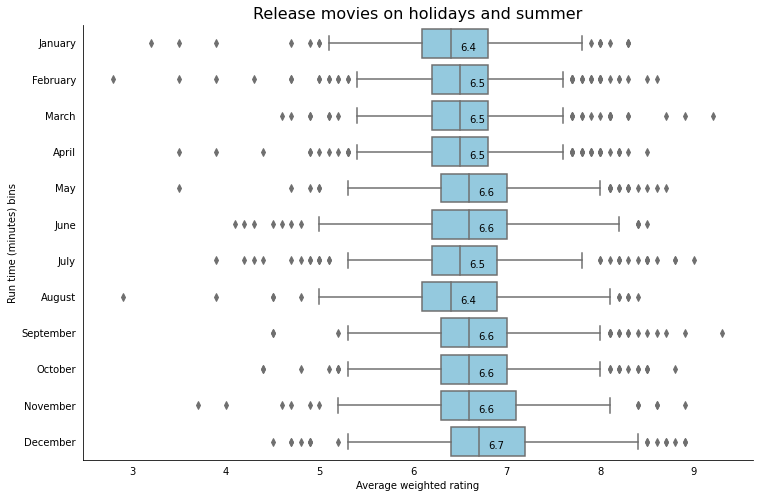

In [130]:
order = ['January','February','March','April','May','June','July','August','September','October','November','December']
plot_boxplot(movie_models_originals,'release_month', title = 'Release movies on holidays and summer', xlabel = 'Average weighted rating', ylabel = 'Run time (minutes) bins', order = order)

#### Genre

In [131]:
movie_models_originals['genres_list'] = movie_models_originals['genres_x'].apply(lambda x: x.split(','))

In [132]:
exploded_genres = movie_models_originals.explode('genres_list')

In [133]:
atleast_100 =  exploded_genres.groupby('genres_list').size().sort_values(ascending = False)[:18].index.values
temp_data = exploded_genres[exploded_genres['genres_list'].isin(atleast_100)]

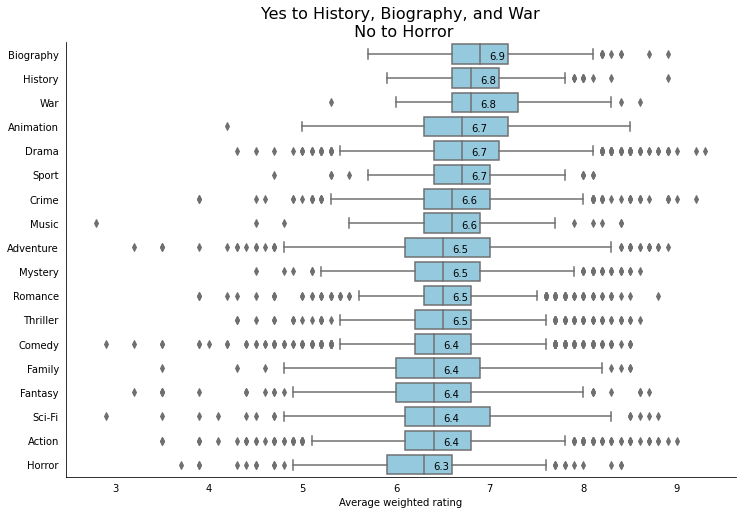

In [134]:
plot_boxplot(temp_data, 'genres_list', 'Yes to History, Biography, and War\n No to Horror', ylabel='', xlabel='Average weighted rating')

#### Director

In [135]:
temp_data = movie_models_originals.copy()
director_mapping = {1:'With a well-known director',0:'Without a well-known director'}
temp_data['has_well_known_director'] = temp_data['has_well_known_director'].map(director_mapping)

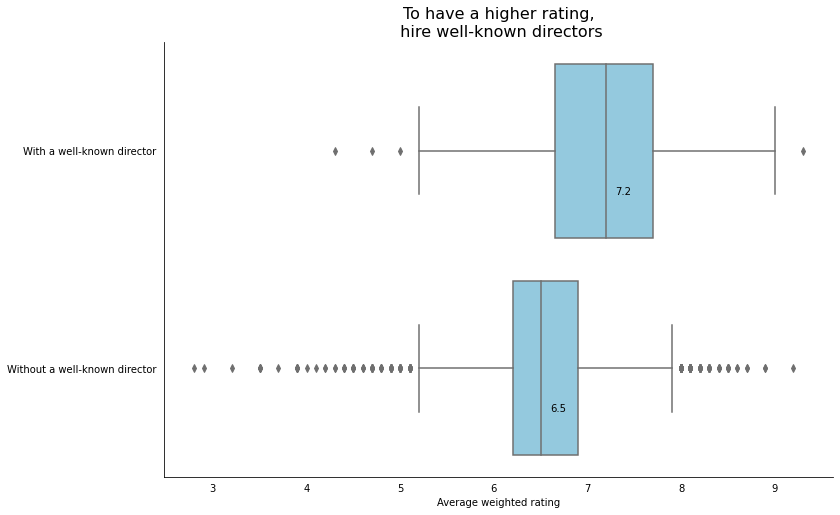

In [136]:

plot_boxplot(temp_data, 'has_well_known_director','To have a higher rating,\n hire well-known directors', xlabel='Average weighted rating', ylabel='')

#### Popularity

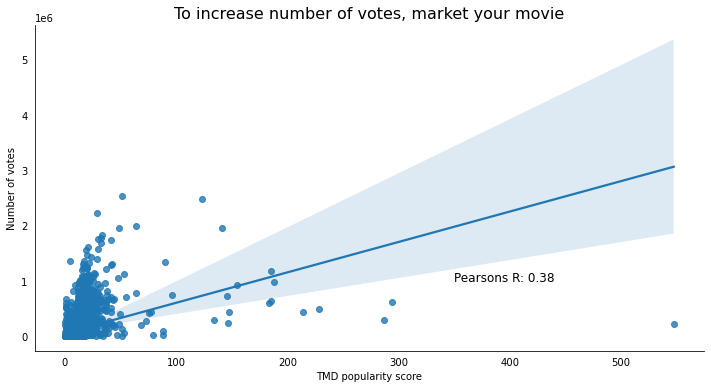

In [137]:
with sns.axes_style({
'xtick.bottom': False,
 'xtick.top': False,
 'ytick.left': False,
 'ytick.right': False,
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': False,
 'axes.spines.top': False
}):
    plt.figure(figsize=(12,6))
    ax = sns.regplot(data = movie_models_originals, x = 'popularity', y= 'numVotes')
    ax.set_title('To increase number of votes, market your movie', fontsize = 16)
    ax.set_ylabel('Number of votes')
    ax.set_xlabel('TMD popularity score')
    ax.text(350, 1000000, 'Pearsons R: ' + str(np.round(np.corrcoef(movie_models_originals['popularity'], movie_models_originals['numVotes'])[0,1], 2)), fontsize = 12)